## HACKDAY COMUNIDADE DS - 7 EDIÇÃO
#### *Previsão de Vendas*





# 0.0 Imports

In [1]:

import random
import datetime
import math

import pandas   as pd
import numpy    as np
import seaborn  as sns
import matplotlib.pyplot as plt
import lightgbm as lgb



from sklearn.linear_model    import Ridge
from sklearn.tree            import DecisionTreeRegressor
from sklearn.impute          import SimpleImputer, KNNImputer
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.preprocessing   import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### 0.1 Suport Functions

In [2]:
# função de transformaçao de distancia em polegadas para km
def km_para_polegadas(distancia_km):
    fator_conversao = 39370.1
    return distancia_km * fator_conversao

# calculo da metrica
def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame (  {'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse}, index=[0])


# 1.0 Descrição dos Dados

### 1.1 Load Data

In [3]:
# carregando dados

df_train = pd.read_csv ('/content/drive/MyDrive/HackDay - 7 Edição/train.csv')
df_store = pd.read_csv ('/content/drive/MyDrive/HackDay - 7 Edição/stores.csv')
df_features = pd.read_csv ('/content/drive/MyDrive/HackDay - 7 Edição/train_features.csv')

### 1.2 Data Merge

In [4]:
# merge dataframes
# merge das tabelas de 'train' e 'store'
df_feature_store = pd.merge(df_train, df_store, how='left', on='loja')

# merge das tabelas 'train e store' com 'train_features'
df_merge = pd.merge(df_feature_store, df_features, how = 'left', on=['loja', 'data'])
df_merge = df_merge.drop('feriado_y', axis = 1)
#df_merge.head(10)

### 1.3 Dtypes


In [5]:
# copia de segurança
df1 = df_merge.copy()

In [6]:
# transformando a data de 'object' para 'Datetime'
df1['data'] = pd.to_datetime('2023-' + df1['data'], format='%Y-%m-%d')

In [7]:
# conferindo os typois de dados e se ha necessidade de transformação de algum
df1.dtypes

,0
id,int64
loja,int64
setor,int64
data,datetime64[ns]
vendas_semanais,float64
feriado_x,object
tipo,object
tamanho,float64
temperatura,float64
combustivel,float64


### 1.4 Fillout NaN

In [8]:
# conferindo os dados faltantes
df1.isna().sum()

,0
id,0
loja,0
setor,0
data,0
vendas_semanais,12862
feriado_x,0
tipo,0
tamanho,33327
temperatura,47945
combustivel,52989


In [9]:
# SUBSTITUINDO DADOS FALTANTES

# vendas semanais - substiuindo pela mediana com base na loja e setor
# Calcular a média do grupo e adicionar à coluna 'mean_group'
df1['mean_group'] = df1.groupby(['loja', 'setor'])['vendas_semanais'].transform('mean')

# Mesclar o DataFrame com a média do grupo
df1 = df1.merge(df1.groupby(['loja', 'setor'])['vendas_semanais'].mean().reset_index(),
                on=['loja', 'setor'],
                how='left',
                suffixes=('', '_mean'))

#substituindo os faltantes pela media
df1['vendas_semanais'] = df1['vendas_semanais'].fillna(df1['vendas_semanais_mean'])

# excluindo colunas que nao serao mais necessarias
col_drops = ['vendas_semanais_mean', 'mean_group']
df1 = df1.drop(col_drops, axis=1)
# subsiuindo os que ainda faltaram
df1['vendas_semanais'] = df1['vendas_semanais'].fillna(df1['vendas_semanais'].mean())

# tamanho - substituido por mediana
# usando KNN para estipular os valores que serao substituidos aonde nao estiver
#df1['tamanho'] = df1['tamanho'].fillna(df1['tamanho'].median())
columns = ['tamanho']
num_impute = KNNImputer(n_neighbors=5)
aux_input = df1[columns].values.reshape(-1, len(columns))
vs_inputed = num_impute.fit_transform(aux_input)
df1[columns] = vs_inputed

# temperatura - susbtituindo por média
df1['temperatura'] = df1['temperatura'].fillna(df1['temperatura'].mean())

# Combustível - substiuido pela media
df1['combustivel'] = df1['combustivel'].fillna(df1['combustivel'].median())

# descontos - substituido por zero
df1[['desconto_1', 'desconto_2', 'desconto_3', 'desconto_4', 'desconto_5']] = df1[['desconto_1', 'desconto_2', 'desconto_3', 'desconto_4', 'desconto_5']].fillna(0)

# distancia_competidores - substituindo por valor alto (200)
# convertendo polegadas em KM
df1['distancia_competidores'] = df1['distancia_competidores'].apply(km_para_polegadas)
# realizando substiuição
df1['distancia_competidores'] = df1['distancia_competidores'].apply(lambda x: 200 if math.isnan( x ) else x)



In [10]:
# conferindo se todas as colunas com dados faltantes foram substituidos
df1.isna().sum()

,0
id,0
loja,0
setor,0
data,0
vendas_semanais,0
feriado_x,0
tipo,0
tamanho,0
temperatura,0
combustivel,0


### 1.5 Descrição estatistical

In [11]:
# criar dois bancos de dados separado em dados categoricos e numericos
num_atributes = df1.select_dtypes(include=['int64', 'float64'])
cat_atributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [12]:
# verificando quantas variaveis categorigas existentes
cat_atributes.apply(lambda x: x.unique().shape[0])

,0
feriado_x,2
tipo,3


In [13]:
# análise descritiva dos dados numericos

# analise de tendencia central (media e mediana)
atc1 = pd.DataFrame(num_atributes.apply(np.mean)).T # media
atc2 = pd.DataFrame(num_atributes.apply(np.median)).T # mediana

# analise de disperção (desvio padrao, minimo, maximo, range, skew e kurtosis)
a1 = pd.DataFrame(num_atributes.apply(np.std)).T #desvio padrao
a2 = pd.DataFrame(num_atributes.apply(min)).T #minimo
a3 = pd.DataFrame(num_atributes.apply(max)).T #maximo
a4 = pd.DataFrame(num_atributes.apply(lambda x: x.max() - x.min())).T #range
a5 = pd.DataFrame(num_atributes.apply(lambda x: x.skew())).T #skew
a6 = pd.DataFrame(num_atributes.apply(lambda x: x.kurtosis())).T #kurtosis

#concatenação dos dataframes
metricas = pd.concat([a2, a3, a4, atc1, atc2, a1, a5, a6]).T.reset_index()
metricas.columns = ['atributos', 'Minimo', 'Maximo', 'Range', 'Media', 'Mediana', 'Desvio Padrao', 'Skew', 'Kurtosis']


In [14]:
#tabela com as metricas
metricas

,atributos,Minimo,Maximo,Range,Media,Mediana,Desvio Padrao,Skew,Kurtosis
0,id,140679.000000,2.760630e+05,1.353840e+05,2.083710e+05,208371.000000,3.908228e+04,0.000000,-1.200000
1,loja,1.000000,4.500000e+01,4.400000e+01,2.221068e+01,22.000000,1.278326e+01,0.075506,-1.147005
2,setor,1.000000,9.900000e+01,9.800000e+01,4.415033e+01,37.000000,3.045142e+01,0.362279,-1.211266
3,vendas_semanais,-1321.480000,9.999674e+05,1.001289e+06,6.304690e+04,9892.220000,1.891546e+05,4.043910,14.865533
4,tamanho,34875.000000,2.196220e+05,1.847470e+05,1.326191e+05,132619.110310,4.962218e+04,-0.302176,-0.386313
5,temperatura,-18.922222,3.758889e+01,5.651111e+01,1.573373e+01,15.733733,8.627258e+00,-0.526558,0.915559
6,combustivel,2.891000,4.211000e+00,1.320000e+00,3.607673e+00,3.623000,2.234476e-01,-0.693114,1.668562
7,desconto_1,0.000000,3.434814e+04,3.434814e+04,3.888249e+02,0.000000,2.461120e+03,8.519596,84.869507
8,desconto_2,0.000000,4.402161e+04,4.402161e+04,2.262319e+02,0.000000,1.933270e+03,12.832105,209.409016
9,desconto_3,0.000000,1.134490e+03,1.134490e+03,9.222364e+00,0.000000,6.485111e+01,10.138913,125.408630


#### 1.5.1 Visualização dos resultados em gráficos

<ipython-input-15-6ec0c66bc248>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Atributo', y='Média', data=atc1, ax=axes[0, 0], palette='viridis')
<ipython-input-15-6ec0c66bc248>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Atributo', y='Mediana', data=atc2, ax=axes[0, 1], palette='viridis')
<ipython-input-15-6ec0c66bc248>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Atributo', y='Desvio Padrão', data=a1, ax=axes[1, 0], palette='viridis')
<ipython-input-15-6ec0c66bc248>:29: FutureWarning: 

Passing `palette` without assi

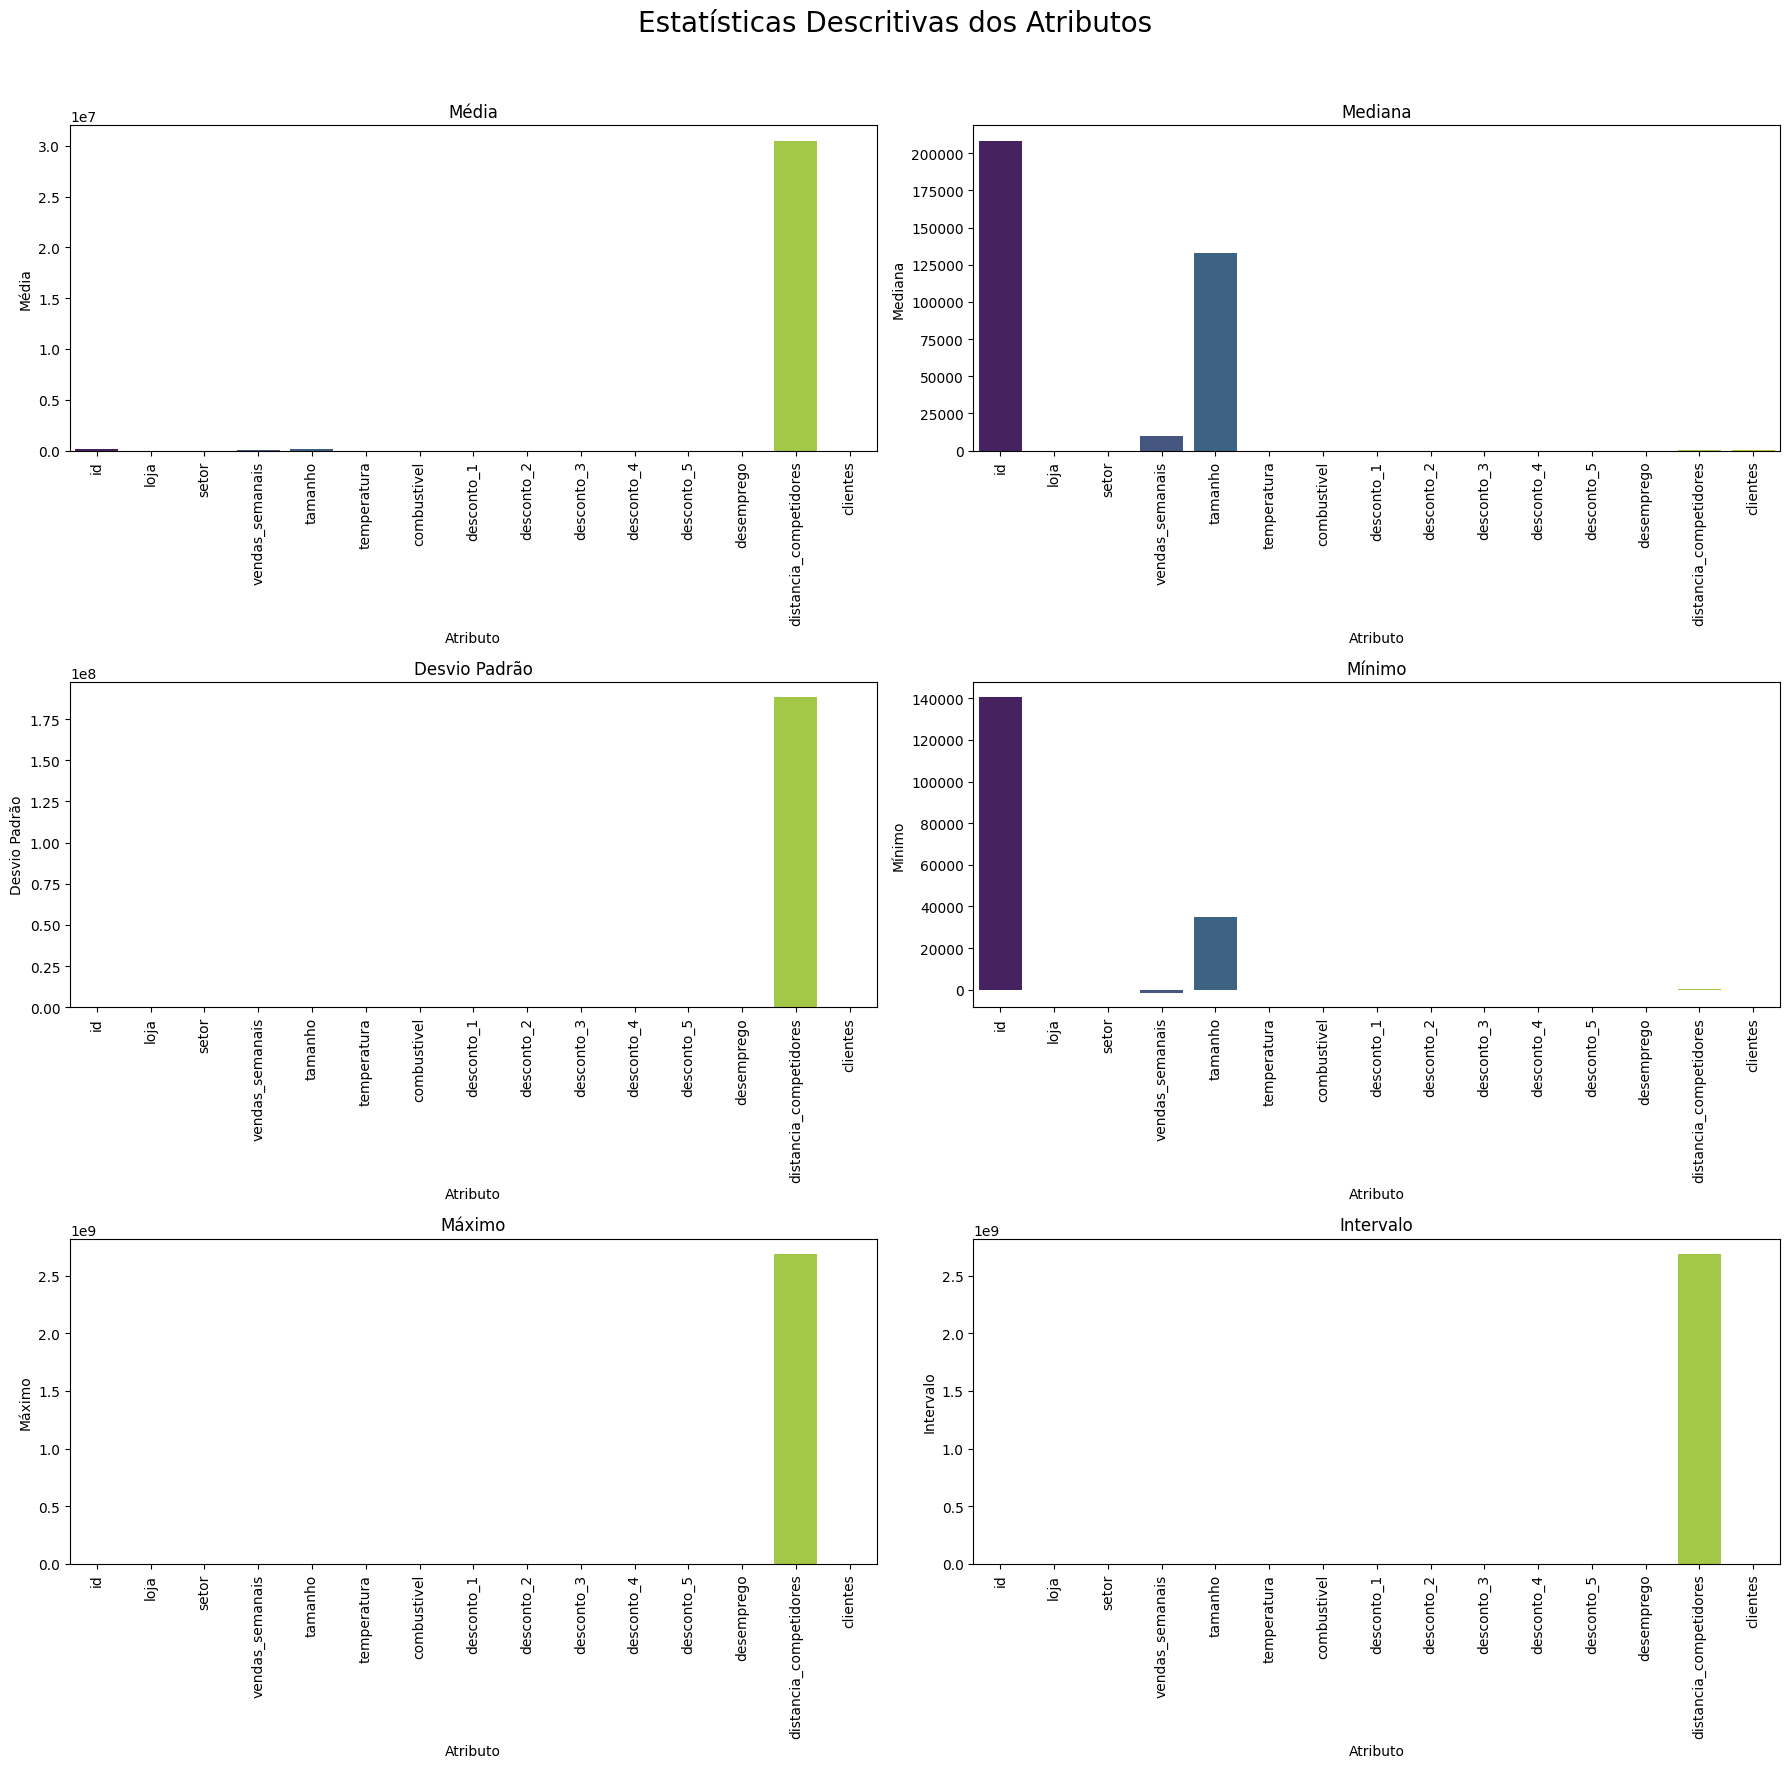

In [15]:
# Transpondo para facilitar a visualização
atc1 = atc1.melt(var_name='Atributo', value_name='Média')
atc2 = atc2.melt(var_name='Atributo', value_name='Mediana')
a1 = a1.melt(var_name='Atributo', value_name='Desvio Padrão')
a2 = a2.melt(var_name='Atributo', value_name='Mínimo')
a3 = a3.melt(var_name='Atributo', value_name='Máximo')
a4 = a4.melt(var_name='Atributo', value_name='Intervalo')

# Configurações de gráficos
fig, axes = plt.subplots(3, 2, figsize=(18, 18))  # 3 linhas x 2 colunas
fig.suptitle('Estatísticas Descritivas dos Atributos', fontsize=20)

# Gráfico de Média
sns.barplot(x='Atributo', y='Média', data=atc1, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Média')
axes[0, 0].tick_params(axis='x', rotation=90)

# Gráfico de Mediana
sns.barplot(x='Atributo', y='Mediana', data=atc2, ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('Mediana')
axes[0, 1].tick_params(axis='x', rotation=90)

# Gráfico de Desvio Padrão
sns.barplot(x='Atributo', y='Desvio Padrão', data=a1, ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Desvio Padrão')
axes[1, 0].tick_params(axis='x', rotation=90)

# Gráfico de Mínimo
sns.barplot(x='Atributo', y='Mínimo', data=a2, ax=axes[1, 1], palette='viridis')
axes[1, 1].set_title('Mínimo')
axes[1, 1].tick_params(axis='x', rotation=90)

# Gráfico de Máximo
sns.barplot(x='Atributo', y='Máximo', data=a3, ax=axes[2, 0], palette='viridis')
axes[2, 0].set_title('Máximo')
axes[2, 0].tick_params(axis='x', rotation=90)

# Gráfico de Intervalo (Range)
sns.barplot(x='Atributo', y='Intervalo', data=a4, ax=axes[2, 1], palette='viridis')
axes[2, 1].set_title('Intervalo')
axes[2, 1].tick_params(axis='x', rotation=90)

# Ajuste do layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

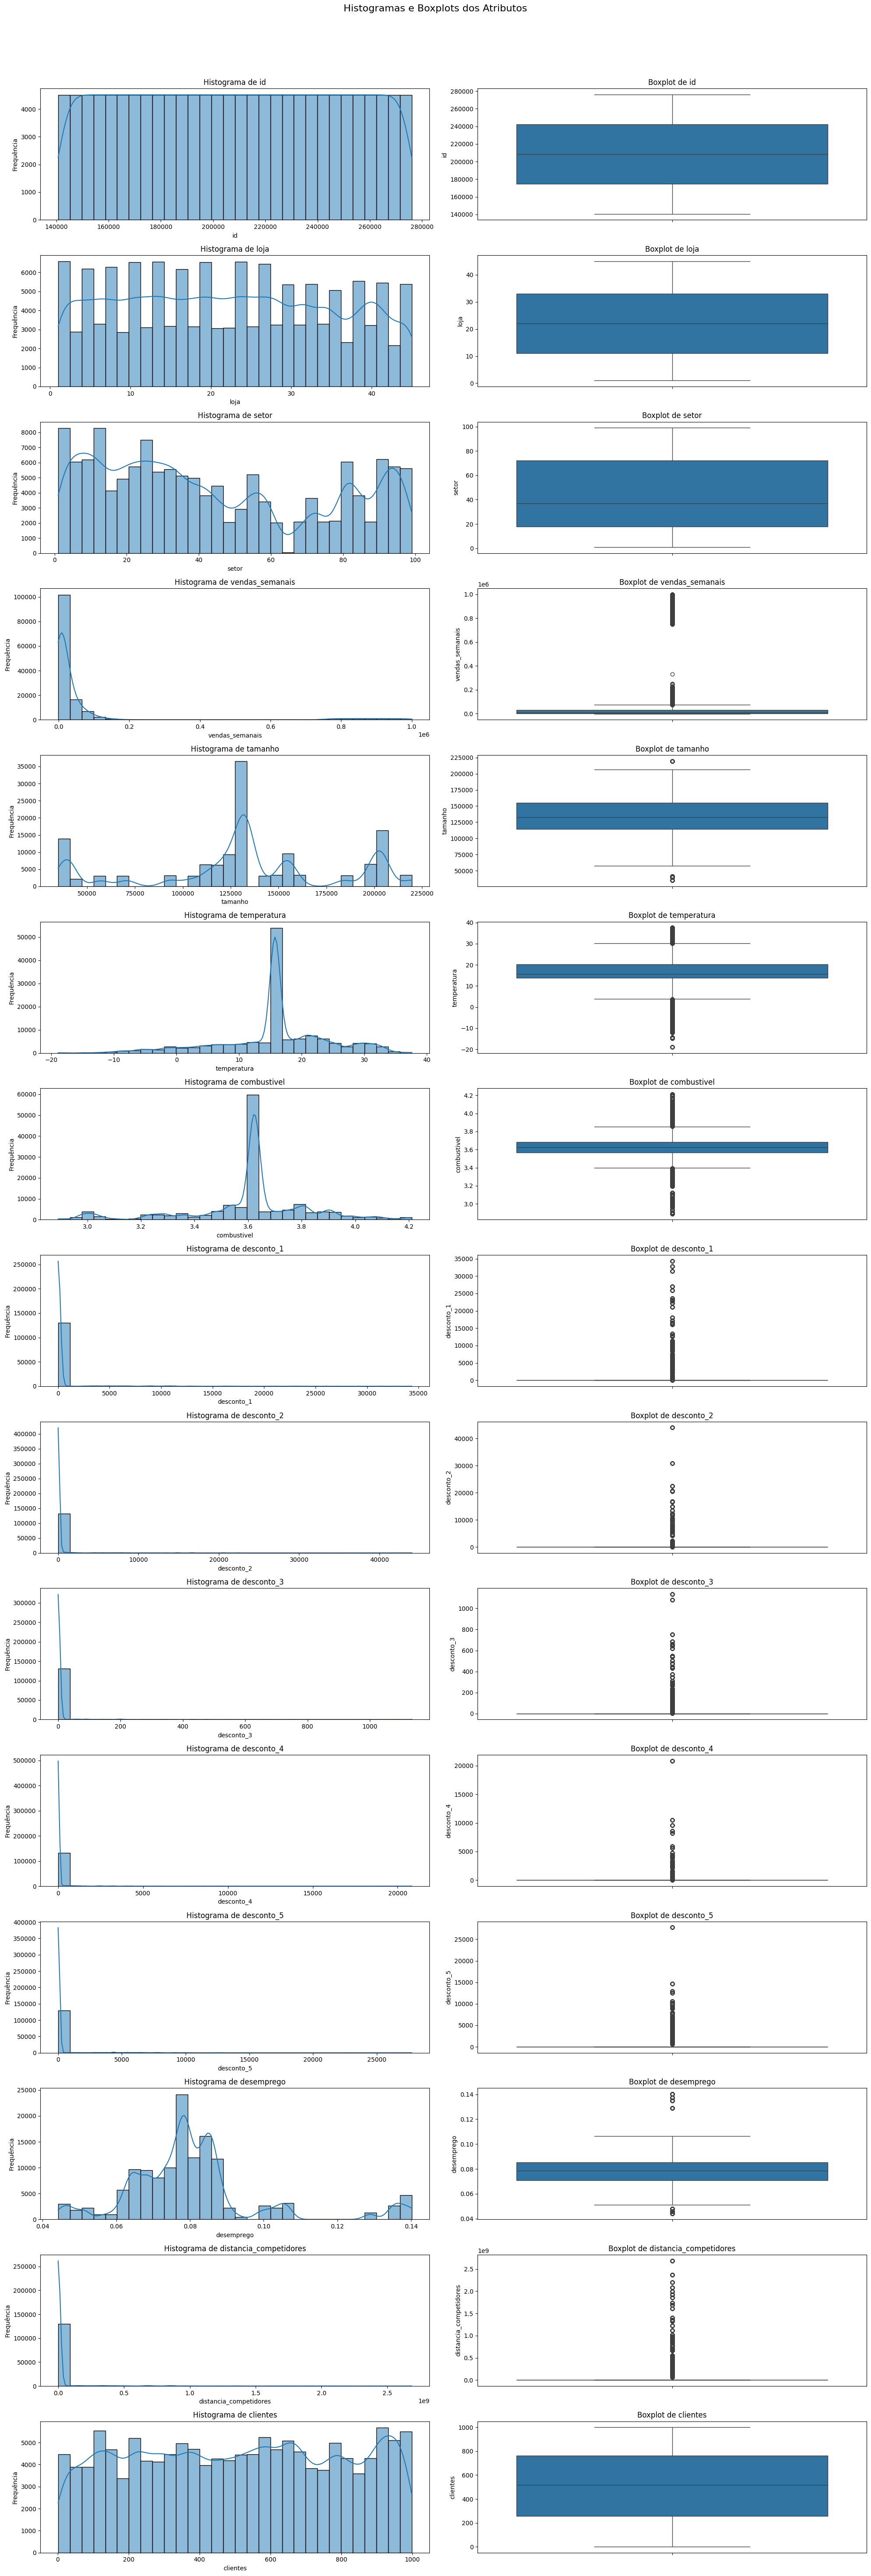

In [16]:
# Configuração da figura e dos subplots
fig, axes = plt.subplots(15, 2, figsize=(20, 60))
fig.suptitle('Histogramas e Boxplots dos Atributos', fontsize=16)

# Loop para criar os gráficos para cada atributo
for i, col in enumerate(num_atributes):
    # Histograma
    sns.histplot(num_atributes[col], kde=True, bins=30, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histograma de {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequência')

    # Boxplot
    sns.boxplot(y=num_atributes[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de {col}')
    axes[i, 1].set_ylabel(col)

# Ajustar layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<ipython-input-17-761e59401dab>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Atributo', y='Skewness', data=a5, palette='viridis')


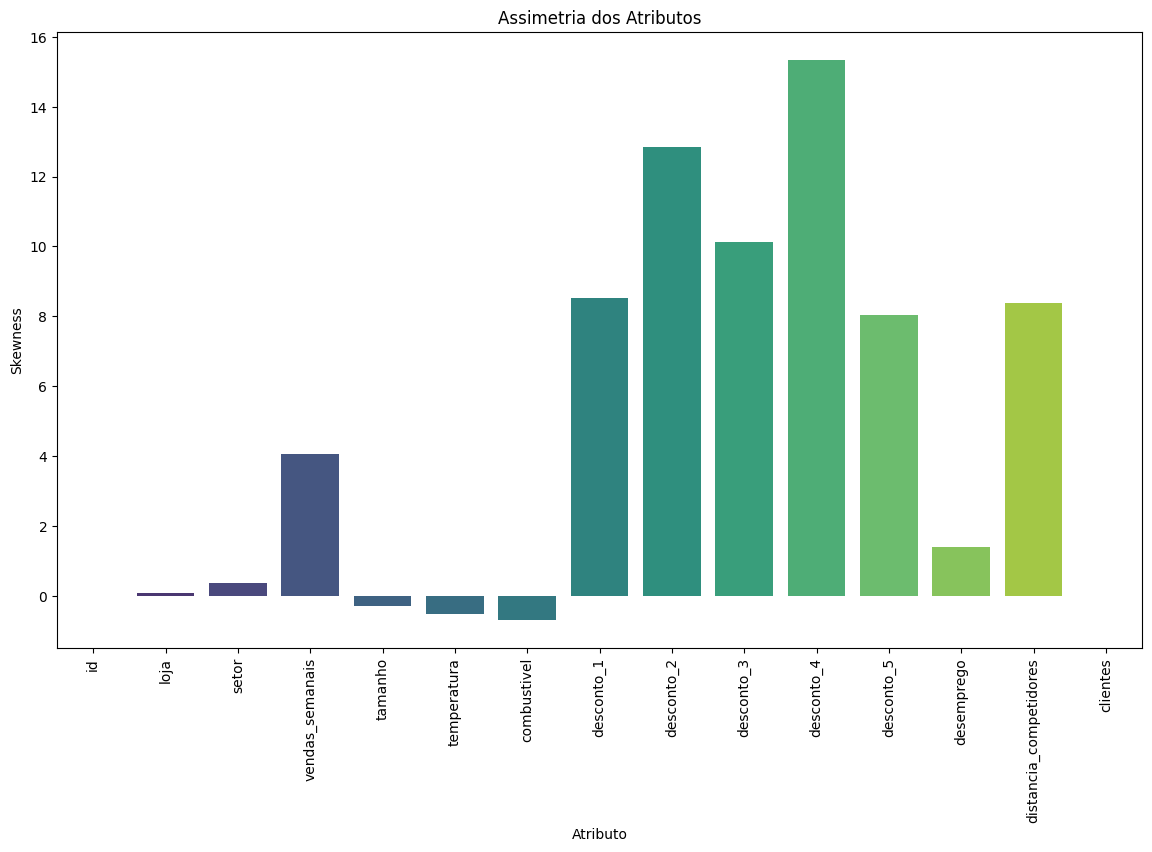

In [17]:
# Se a5 tem apenas uma linha, você pode renomear as colunas para atributos
a5.columns = num_atributes.columns
a5 = a5.melt(var_name='Atributo', value_name='Skewness')

# Plotar a assimetria
plt.figure(figsize=(14, 8))
sns.barplot(x='Atributo', y='Skewness', data=a5, palette='viridis')
plt.xticks(rotation=90)  # Rotacionar os nomes dos atributos para melhor legibilidade
plt.title('Assimetria dos Atributos')
plt.xlabel('Atributo')
plt.ylabel('Skewness')
plt.show()

<ipython-input-18-6da511f9aa15>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Atributo', y='Curtose', data=a6, palette='viridis')


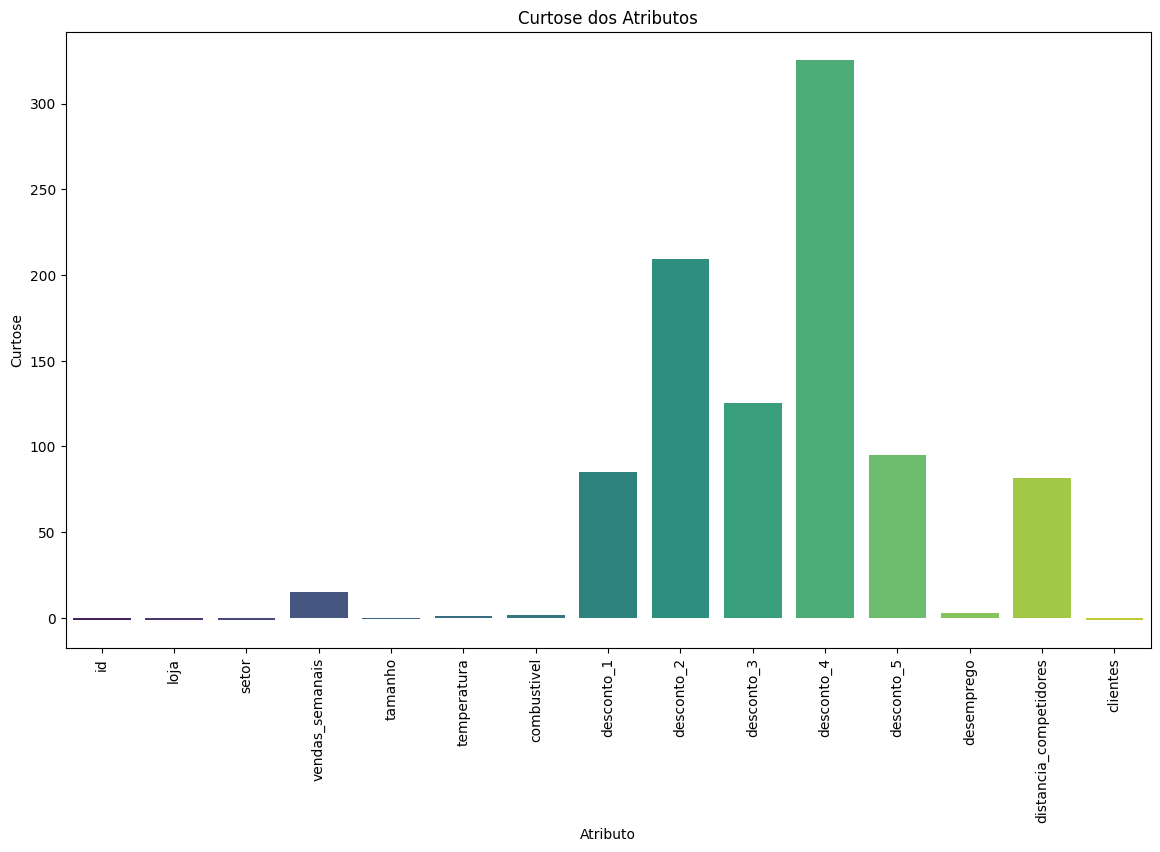

In [18]:
# Se a6 tem apenas uma linha, você pode renomear as colunas para atributos
a6.columns = num_atributes.columns
a6 = a6.melt(var_name='Atributo', value_name='Curtose')

# Plotar a curtose
plt.figure(figsize=(14, 8))
sns.barplot(x='Atributo', y='Curtose', data=a6, palette='viridis')
plt.xticks(rotation=90)  # Rotacionar os nomes dos atributos para melhor legibilidade
plt.title('Curtose dos Atributos')
plt.xlabel('Atributo')
plt.ylabel('Curtose')
plt.show()


# 2.0 Feauture Engineer

In [19]:
df2 = df1.copy()

In [20]:
# extraindo as datas e criando uma coluna para mes, dia e semana do ano
# mes
df2['mes'] = df1['data'].dt.month

# dia
df2['dia'] = df1['data'].dt.day

# s emana_ano
df2['semana_ano'] = df2['data'].dt.isocalendar().week
df2['semana_ano'] = df2['semana_ano'].astype('int64')


In [21]:
#  somando todos os descontos e criado uma coluna com o valor total
df2['desconto_total'] = df2[['desconto_1', 'desconto_2', 'desconto_3', 'desconto_4', 'desconto_5']].sum(axis=1)

In [22]:
# tamanho da loja com base nos quartis
df2['categoria_tamanho'] = pd.qcut(df2['tamanho'], q=[0, 0.25, 0.5, 0.75, 1], labels=['Muito Pequena', 'Pequena', 'Média', 'Grande'])

In [23]:
# renomeando a coluna 'feriado_x' para 'feriado'
df2 = df2.rename(columns={'feriado_x': 'feriado'})


In [24]:
# adicionando coluna das verdas por tipo de loja
vendas_por_tipo = df2.groupby('tipo')['vendas_semanais'].sum().reset_index()

# Renomear a coluna para evitar conflito de nomes
vendas_por_tipo = vendas_por_tipo.rename(columns={'vendas_semanais': 'soma_vendas_tipo'})

# Mesclar os resultados de volta ao DataFrame original com base na coluna 'tipo'
df2 = pd.merge(df2, vendas_por_tipo, on='tipo', how='left')


In [25]:
# adicionando coluna das verdas por setor
vendas_por_setor = df2.groupby('setor')['vendas_semanais'].sum().reset_index()

# Renomear a coluna para evitar conflito de nomes
vendas_por_setor = vendas_por_setor.rename(columns={'vendas_semanais': 'soma_vendas_setor'})

# Mesclar os resultados de volta ao DataFrame original com base na coluna 'tipo'
df2 = pd.merge(df2, vendas_por_setor, on='setor', how='left')

In [26]:
# adicionando coluna das verdas por tamanho
vendas_por_tamanho = df2.groupby('tamanho')['vendas_semanais'].sum().reset_index()

# Renomear a coluna para evitar conflito de nomes
vendas_por_tamanho = vendas_por_tamanho.rename(columns={'vendas_semanais': 'soma_vendas_tamanho'})

# Mesclar os resultados de volta ao DataFrame original com base na coluna 'tipo'
df2 = pd.merge(df2, vendas_por_tamanho, on='tamanho', how='left')

# 3.0 Filtragem de Variáveis

In [27]:
df3 = df2.copy()

In [28]:
# selecionando semanas onde teve venda entre 0 e 7000000
df3 = df3[(df3['vendas_semanais'] > 0) & (df3['vendas_semanais'] < 700000)]

In [29]:
df3.columns


Index(['id', 'loja', 'setor', 'data', 'vendas_semanais', 'feriado', 'tipo',
       'tamanho', 'temperatura', 'combustivel', 'desconto_1', 'desconto_2',
       'desconto_3', 'desconto_4', 'desconto_5', 'desemprego',
       'distancia_competidores', 'clientes', 'mes', 'dia', 'semana_ano',
       'desconto_total', 'categoria_tamanho', 'soma_vendas_tipo',
       'soma_vendas_setor', 'soma_vendas_tamanho'],
      dtype='object')

In [30]:
# excluindo colunas que nao irao agregar na predição
cols_drop = ['tamanho', 'desconto_1', 'desconto_2', 'desconto_3', 'desconto_4', 'desconto_5']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 EDA

In [31]:
df4 = df3.copy()

<ipython-input-32-e554c07499c8>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['vendas_semanais']);


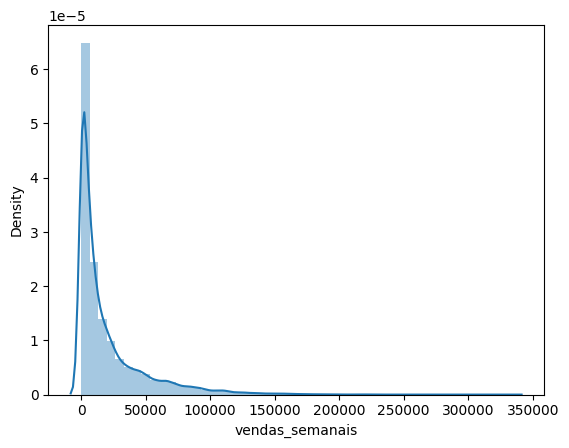

In [ ]:
# verificando a distribuição da variável vendas
sns.distplot(df4['vendas_semanais']);

<Axes: xlabel='tipo', ylabel='vendas_semanais'>

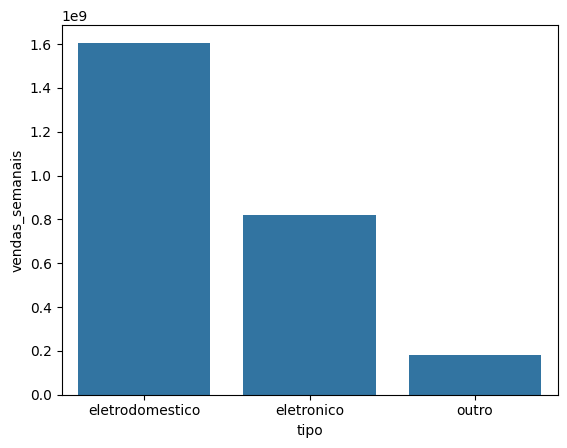

In [ ]:
# analisando venda por cada tipo
venda_tipo = df4[['vendas_semanais', 'tipo']].groupby('tipo').sum().reset_index()
sns.barplot(x= 'tipo', y= 'vendas_semanais', data= venda_tipo)

<Axes: xlabel='loja', ylabel='setor'>

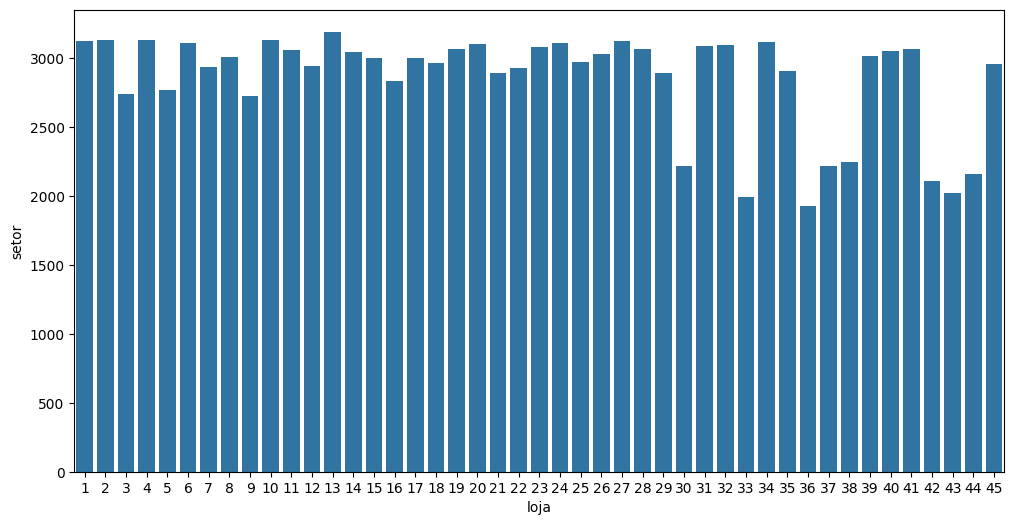

In [ ]:
# quantos setores tem em cada loja
loja_setor = df4[['loja', 'setor']].groupby('loja').count().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='loja', y='setor', data=loja_setor)

<Axes: xlabel='setor', ylabel='vendas_semanais'>

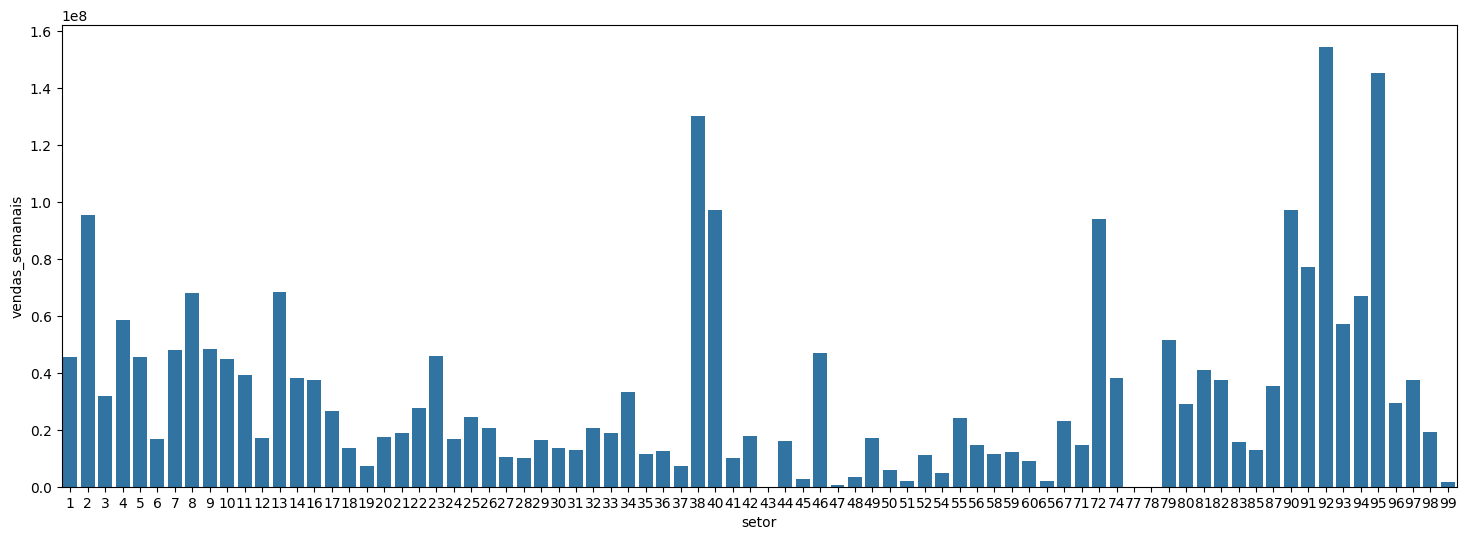

In [ ]:
# analisando venda por setor
venda_tipo = df4[['vendas_semanais', 'setor']].groupby('setor').sum().reset_index()
plt.figure(figsize=(18, 6))
sns.barplot(x= 'setor', y= 'vendas_semanais', data= venda_tipo)

<ipython-input-35-d5f5449836c8>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  venda_tipo = df4[['vendas_semanais', 'categoria_tamanho']].groupby('categoria_tamanho').sum().reset_index()


<Axes: xlabel='categoria_tamanho', ylabel='vendas_semanais'>

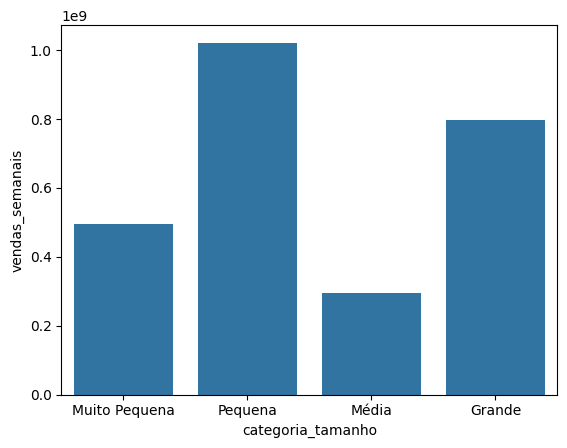

In [ ]:
# analisando venda por tamanho da loja
venda_tipo = df4[['vendas_semanais', 'categoria_tamanho']].groupby('categoria_tamanho').sum().reset_index()
sns.barplot(x= 'categoria_tamanho', y= 'vendas_semanais', data= venda_tipo)

<ipython-input-87-e5e521565bcf>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cliente_loja = df4[['clientes', 'categoria_tamanho']].groupby('categoria_tamanho').count().reset_index()


<Axes: xlabel='categoria_tamanho', ylabel='clientes'>

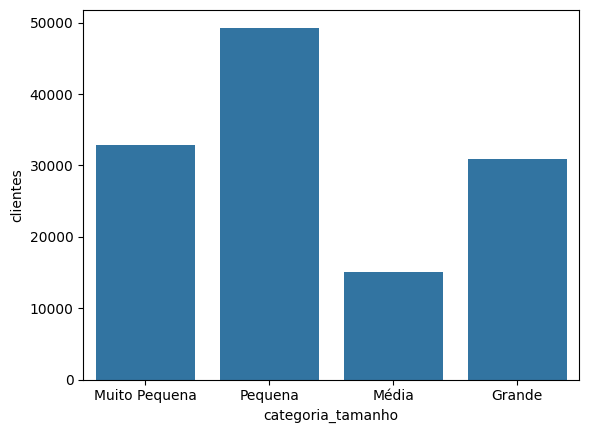

In [ ]:
# quantidade de clientes por tamanho de loja
cliente_loja = df4[['clientes', 'categoria_tamanho']].groupby('categoria_tamanho').count().reset_index()
sns.barplot(x= 'categoria_tamanho', y= 'clientes', data= cliente_loja)

<Axes: xlabel='feriado', ylabel='vendas_semanais'>

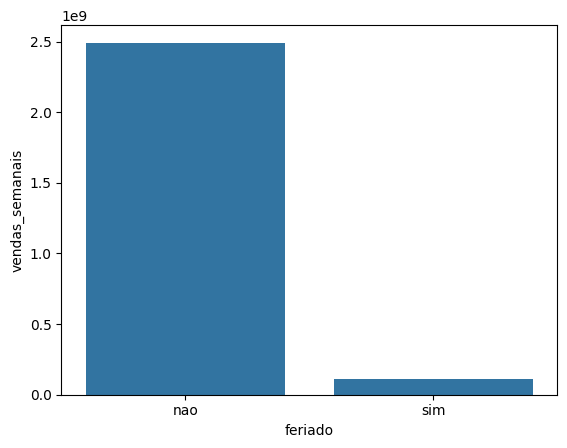

In [ ]:
# analisando vendas por feriado
venda_feriado = df4[['vendas_semanais', 'feriado']].groupby('feriado').sum().reset_index()
sns.barplot(x= 'feriado', y= 'vendas_semanais', data= venda_feriado)

<ipython-input-37-b0ea3c9545a8>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( df4[df4['feriado'] == 'sim']['vendas_semanais'], label= 'feriado', shade=True)
<ipython-input-37-b0ea3c9545a8>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( df4[df4['feriado'] == 'nao']['vendas_semanais'], label= 'feriado', shade=True)
<ipython-input-37-b0ea3c9545a8>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot( df4[df4['tipo'] == 'eletrodomestico']['vendas_semanais'], label= 'tipo', shade=True)
<ipython-input-37-b0ea3c9545a8>:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become a

<Axes: xlabel='vendas_semanais', ylabel='Density'>

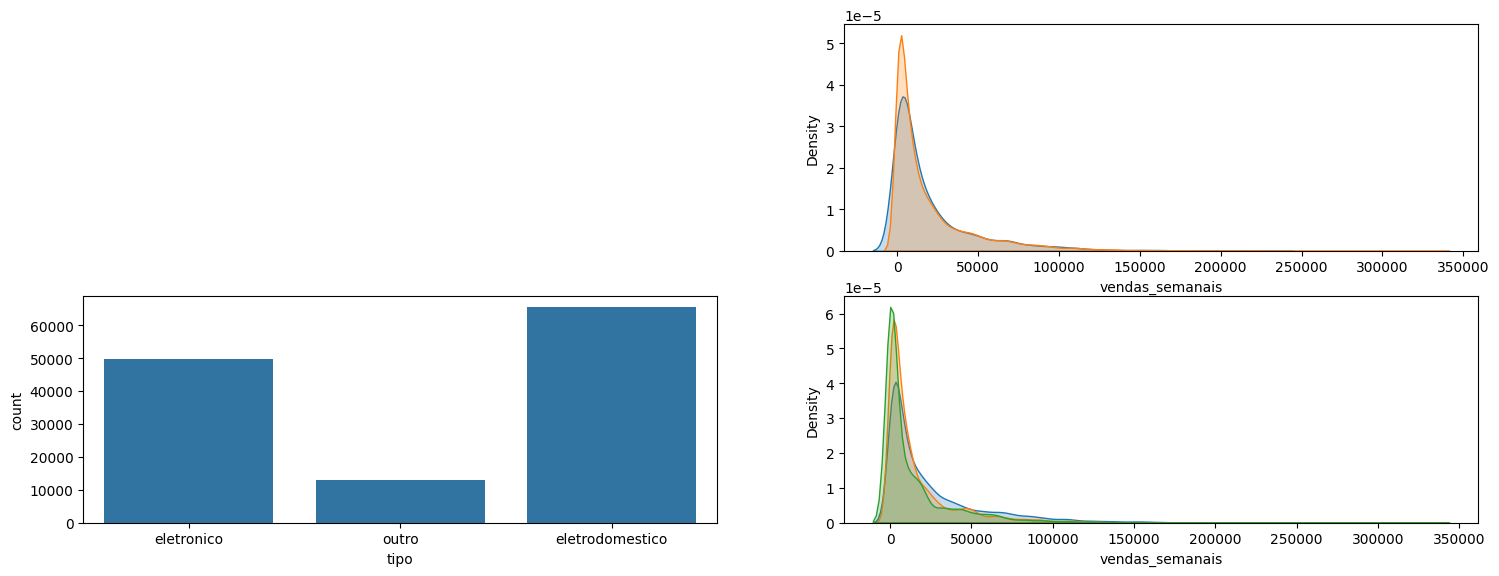

In [ ]:
#separando as vendas por feriado:
plt.figure(figsize=(18,10))
plt.subplot(3, 2, 2)
sns.kdeplot( df4[df4['feriado'] == 'sim']['vendas_semanais'], label= 'feriado', shade=True)

# easter_holiday
sns.kdeplot( df4[df4['feriado'] == 'nao']['vendas_semanais'], label= 'feriado', shade=True)

# store_type
# plotando o grafico de tipo de loja
plt.subplot(3, 2, 3)
sns.countplot(x='tipo', data=df4)
# separando as vendas por cada tipo de loja e plotando o gráfico:
plt.subplot(3, 2, 4)
sns.kdeplot( df4[df4['tipo'] == 'eletrodomestico']['vendas_semanais'], label= 'tipo', shade=True)
sns.kdeplot( df4[df4['tipo'] == 'eletronico']['vendas_semanais'], label= 'eletronico', shade=True)
sns.kdeplot( df4[df4['tipo'] == 'outro']['vendas_semanais'], label= 'outro', shade=True)


<Axes: >

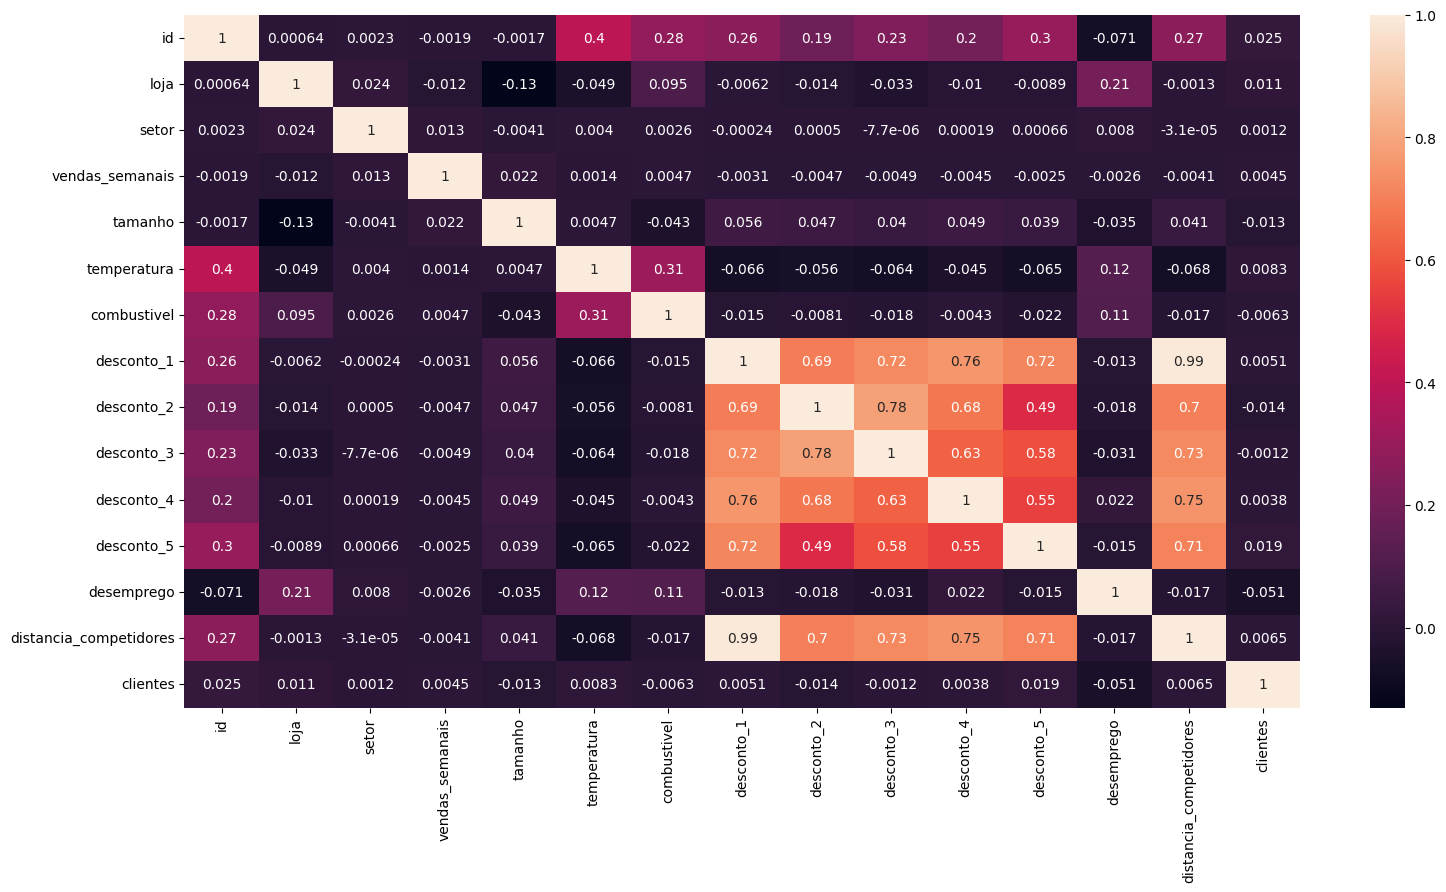

In [ ]:
# correlação dos dados numericos
plt.figure(figsize =(18,9))
correlation = num_atributes.corr(method= 'pearson')
sns.heatmap(correlation, annot= True)

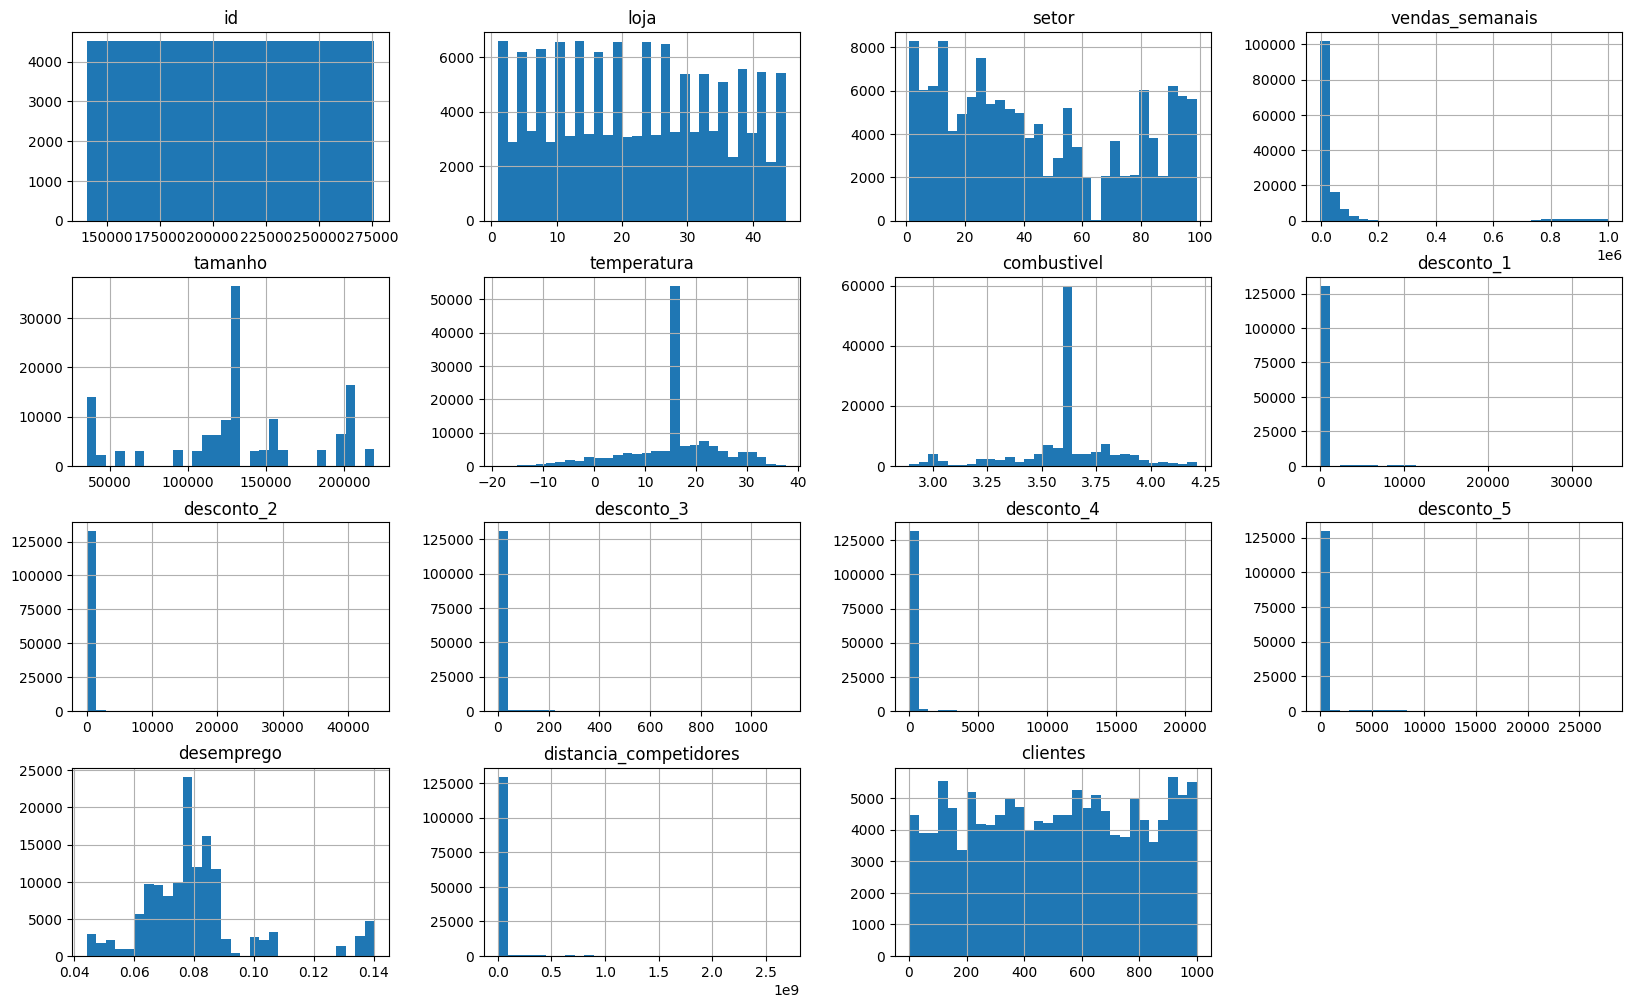

In [ ]:
# histograma de todas as variaveis numericas a fim de sabver sua distribuição
num_atributes.hist(bins=30,figsize=(20, 12));

# 5.0 Preparação dos Dados

In [32]:
df5 = df3.copy()

### 5.2 Encoding

In [33]:
# store type - tecnica Label Encoder
le = LabelEncoder()
oe = OrdinalEncoder()
# tipo
df5['tipo'] = le.fit_transform(df5['tipo'])
df5['tipo'] = df5['tipo'].astype('int64')

# feriado
df5['feriado'] = le.fit_transform(df5['feriado'])

# tamanho
df5[['categoria_tamanho']] = oe.fit_transform(df5[['categoria_tamanho']]).astype('int64')

In [34]:
# trasnformação para que seja entendimo os dias como algo ciclico

# day
df5['dia_sin'] = df5['dia'].apply( lambda x: np.sin( x * ( 2. * np.pi/30) ) )
df5['dia_cos'] = df5['dia'].apply( lambda x: np.cos( x * ( 2. * np.pi/30) ) )

# month
df5['mes_sin'] = df5['mes'].apply( lambda x: np.sin( x * ( 2. * np.pi/12) ) )
df5['mes_cos'] = df5['mes'].apply( lambda x: np.cos( x * ( 2. * np.pi/12) ) )

# week of year
df5['semana_ano_sin'] = df5['semana_ano'].apply( lambda x: np.sin( x * ( 2. * np.pi/52) ) )
df5['semana_ano_cos'] = df5['semana_ano'].apply( lambda x: np.cos( x * ( 2. * np.pi/52) ) )

### 5.1 Rescaling

In [35]:
rs = RobustScaler()

df5['distancia_competidores'] = rs.fit_transform(df5[['distancia_competidores']].values)
df5['categoria_tamanho'] = rs.fit_transform(df5[['categoria_tamanho']].values)
df5['distancia_competidores'] = rs.fit_transform(df5[['distancia_competidores']].values)
df5['desemprego'] = rs.fit_transform(df5[['desemprego']].values)


In [36]:
# tranformando o target atraves do logaritmo
df5['vendas_semanais'] = np.log1p(df5['vendas_semanais'])

# 6.0 Feature Selection

In [37]:
df6 = df5.copy()

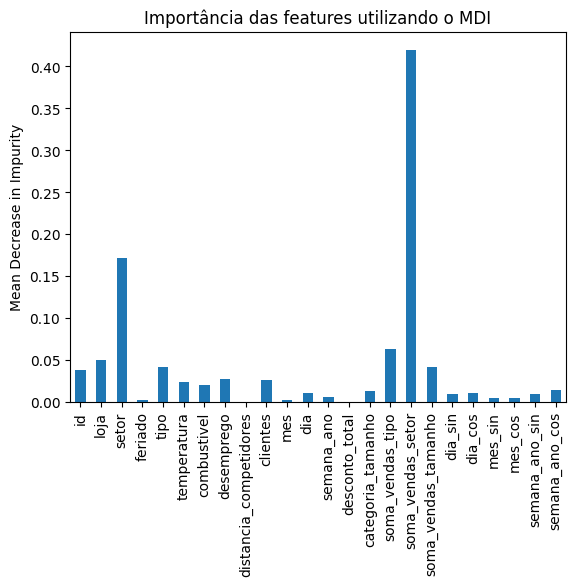

In [41]:
# Treinando um modelo de random forest para selecionar as melhores features para treinar o modelo
# training and test dataset
X_train_n = X_train.drop(['data', 'vendas_semanais'], axis=1).values
Y_train_n = Y_train.values.ravel()

# defindindo a Random Forest, nesse caso sera a Rando Forest Regressor
rf = RandomForestRegressor (n_jobs = -1)

# Pode testar mais valores de estimadores para verificar, porém a diferença na importância das features é pequena.
model_select = rf
model_select.fit(X_train_n, Y_train_n)

# Selecionando as features de maior importância através do modelo treinado
n_features = X_train_n.shape[1]
feature_names = [f"feature {i}" for i in range(n_features)]
importances = model_select.feature_importances_
forest_importances = pd.Series(importances, index = feature_names)

# MDI: calcula a redução média da impureza de cada feature e plota em um gráfico
fig, ax = plt.subplots()
forest_importances.plot.bar(ax = ax)
ax.set_title('Importância das features utilizando o MDI')
ax.set_ylabel('Mean Decrease in Impurity')
X_train_n_columns = df6.drop(['vendas_semanais', 'data'], axis = 1).columns
ax.set_xticklabels(X_train_n_columns)
plt.xticks(rotation = 90);

In [42]:
# melhores colunas selecionadas para o treinamento do modelo

cols_x = ['id',
          'loja',
          'setor',
          'tipo',
          'temperatura',
          'combustivel',
          'desemprego',
          'clientes',
          'categoria_tamanho',
          'soma_vendas_tipo',
          'soma_vendas_setor',
          'soma_vendas_tamanho',
          'dia_sin',
          'dia_cos',
          'mes_sin',
          'mes_cos',
          'semana_ano_sin',
          'semana_ano_cos']


###6.1 Divisão Treino, Teste e Validação

In [39]:
# Identificar a data mais recente disponível
ultima_data = df6[['loja', 'data']].groupby('loja').max().reset_index()['data'].max()

# Calcular a data de separação para o treino
data_separacao = ultima_data - datetime.timedelta(days=5*7)  # 5 semanas antes da última data

# Definir a data de início para o teste (um dia após a data de validação)
data_test_inicio = ultima_data

In [40]:
# Dividisão os dados

# Treinamento: dados antes da data de separação
X_train = df6[df6['data'] <= data_separacao]
Y_train = X_train['vendas_semanais']

# Validação: dados entre a data de separação e a data do teste
X_val = df6[(df6['data'] > data_separacao) & (df6['data'] < data_test_inicio)]
Y_val = X_val['vendas_semanais']

# Teste: dados após a data do teste
X_test = df6[df6['data'] >= data_test_inicio]
Y_test = X_test['vendas_semanais']

# Verificar o tamanho dos conjuntos
print(f'Treinamento: {X_train.shape}')
print(f'Validação: {X_val.shape}')
print(f'Teste: {X_test.shape}')

Treinamento: (114179, 26)
Validação: (11245, 26)
Teste: (2806, 26)


In [43]:
# print para conferir se as datas estao de acordo
print( f"Training Min Date: {X_train['data'].min()}")
print( f"Training Max Date: {X_train['data'].max()}")

print( f"\nTest Min Date: {X_val['data'].min()}")
print( f"Test Max Date: {X_val['data'].max()}" )

print( f"\nTest Min Date: {X_test['data'].min()}")
print( f"Test Max Date: {X_test['data'].max()}" )

Training Min Date: 2023-01-07 00:00:00
Training Max Date: 2023-10-14 00:00:00

Test Min Date: 2023-10-21 00:00:00
Test Max Date: 2023-11-11 00:00:00

Test Min Date: 2023-11-18 00:00:00
Test Max Date: 2023-11-18 00:00:00


In [44]:
cols_x2 = ['id',
           'data',
          'loja',
          'setor',
          'tipo',
           'vendas_semanais',
          'temperatura',
          'combustivel',
          'desemprego',
          'clientes',
          'categoria_tamanho',
          'soma_vendas_tipo',
          'soma_vendas_setor',
          'soma_vendas_tamanho',
          'dia_sin',
          'dia_cos',
          'mes_sin',
          'mes_cos',
          'semana_ano_sin',
          'semana_ano_cos']

In [46]:
# colunas relevantes para o modelo dividido em treino, validação e test
xtrain = X_train[cols_x]
xtest = X_test[cols_x]
xval =X_val[cols_x]

In [49]:
print(f'Treinamento: {xtrain.shape}')
print(f'Validação: {xtest.shape}')
print(f'Teste: {xval.shape}')


Treinamento: (114179, 18)
Validação: (2806, 18)
Teste: (11245, 18)


# 7.0 Modelos de Machine Learning

In [ ]:
df7 = df6.copy()

## 7.1 Random Forest

In [ ]:
# modelo treino
rf = RandomForestRegressor(n_estimators=100, n_jobs= -1, random_state=42).fit (xtrain, Y_train)

# predição
yhat_rf = rf.predict(xtest)

# performance
rf_result = ml_error ('Random Forest', np.expm1(Y_test), np.expm1( yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,8550.243601,9.943139,18746.791418


#### 7.1.1 Hiperparametros

In [ ]:
# parametros a serem testados
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurar o RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)

# Ajustar o modelo
random_search.fit(xtrain, Y_train)

# Melhor modelo
best_rf = random_search.best_estimator_

# Imprimir os melhores parâmetros
print(f'Best parameters: {random_search.best_params_}')

Best parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 20}


In [ ]:
# modelo com hiper parametros
rf = RandomForestRegressor(n_estimators=300,min_samples_split= 10,min_samples_leaf= 4, max_depth= 20, n_jobs= -1, random_state=42).fit (xtrain, Y_train)

# predição (validação)
best_rf = rf.predict(xval)

# performance
rf_result_ = ml_error ('Random Forest', np.expm1(Y_val), np.expm1( best_rf))
rf_result_

,Model Name,MAE,MAPE,RMSE
0,Random Forest,7433.833444,1.514702,18834.241818


#### 7.1.2 Modelo Final

In [ ]:
# predição com os dados de teste
val_rf = rf.predict(xtest)

# performance
rf_result_final = ml_error ('Random Forest', np.expm1(Y_test), np.expm1( val_rf))
rf_result_final

,Model Name,MAE,MAPE,RMSE
0,Random Forest,7352.542938,3.384626,18421.611633


## 7.2 Linear Regression lasso

In [ ]:
# model
lrr = Lasso(alpha= 0.1).fit (xtrain, Y_train)

# predicition
yhat_lrr = lrr.predict(xval)

# performance
lrr_result = ml_error ('Linear Regression - Lasso', np.expm1(Y_val), np.expm1( yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,17207.278404,10.937568,38775.35526


#### 7.2.1 Modelo final

In [ ]:
# predicition
yhat_lrr = lrr.predict(xtest)

# performance
lrr_result_final = ml_error ('Linear Regression - Lasso', np.expm1(Y_test), np.expm1( yhat_lrr))
lrr_result_final

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,16729.392984,8.543029,38063.897808


## 7.3 Regressão de Ridge

In [ ]:
# modelo treinado com dados de treino
alpha =0.1
modelo_ridge = Ridge(alpha=alpha)
modelo_ridge.fit(xtrain, Y_train)


# prediçao com dados de validação
predict_ridge = modelo_ridge.predict(xval)

# performance
ridge_result_final = ml_error ('Ridge Regressor', np.expm1(Y_val), np.expm1( predict_ridge))
ridge_result_final


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.81458e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


,Model Name,MAE,MAPE,RMSE
0,Ridge Regressor,16846.397827,10.112463,36442.36768


### 7.3.1 Modelo final

In [ ]:
# prediçao com dados de teste
predict_ridge = modelo_ridge.predict(xtest)

# performance
ridge_result_final = ml_error ('Ridge Regressor', np.expm1(Y_test), np.expm1( predict_ridge))
ridge_result_final

,Model Name,MAE,MAPE,RMSE
0,Ridge Regressor,16460.474092,7.873845,36146.4307


## 7.4 LightGBM


In [ ]:
# Criar o dataset do LightGBM
train_data = lgb.Dataset(xtrain, label=Y_train)
test_data = lgb.Dataset(X_test, label=Y_test, reference=train_data)

# parametros
parametros = {
    'objective': 'regression',  # Para problemas de regressão
    'metric': 'rmse',  # Métrica de erro quadrático médio (Mean Squared Error)
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9 }

# Número de iterações
num_round = 100

# modelo
modelo = lgb.train(parametros, train_data, num_round)

# predição
yhat_lgbm = modelo.predict(xtest)

# performance
lgbm_result = ml_error ('LightGBM', np.expm1(Y_test), np.expm1( yhat_lgbm))
lgbm_result

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1490
[LightGBM] [Info] Number of data points in the train set: 114179, number of used features: 18
[LightGBM] [Info] Start training from score 8.707867


,Model Name,MAE,MAPE,RMSE
0,LightGBM,9447.336609,2.299203,21146.295961


#### 7.4.1 Tunning Hiperparametors

In [ ]:
# Definir o modelo LGBM
lgbm = lgb.LGBMRegressor()

# Definir o espaço de busca
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [20, 31, 40, 50, 60],
    'max_depth': [-1, 10, 20, 30, 40],
    'min_child_samples': [5, 10, 20, 30, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0]
}

# Configurar o RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist, n_iter=50, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)

# Ajustar o modelo
random_search.fit(xtrain, Y_train)

# Melhor modelo
best_lgbm = random_search.best_estimator_

# Imprimir os melhores parâmetros
print(f'Best parameters: {random_search.best_params_}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1490
[LightGBM] [Info] Number of data points in the train set: 114179, number of used features: 18
[LightGBM] [Info] Start training from score 8.707867
Best parameters: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'num_leaves': 50, 'n_estimators': 400, 'min_child_samples': 5, 'max_depth': 40, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


#### 7.4.2 Validação

In [ ]:
# melhores parametros:'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'num_leaves': 50,
#'n_estimators': 400, 'min_child_samples': 5, 'max_depth': 40, 'learning_rate': 0.05, 'colsample_bytree': 0.6

# Criar o dataset do LightGBM com dados de treino
train_data = lgb.Dataset(xtrain, label=Y_train)
test_data = lgb.Dataset(X_test, label=Y_test, reference=train_data)

#  modelo com hiperparametros
parametros = {
    'objective': 'regression',  # Para problemas de regressão
    'metric': 'rmse',  # Métrica de erro quadrático médio (Mean Squared Error)
    'boosting_type': 'gbdt',
    'subsample': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'num_leaves': 50,
    'n_estimators': 400,
    'learning_rate': 0.05,
    'min_child_samples': 5,
    'feature_fraction': 0.9,
    'colsample_bytree': 0.6}

# Número de iterações
num_round = 100

# modelo com dados de treino
modelo = lgb.train(parametros, train_data, num_round)

# predição com os dados de validação
yhat_lgbm = modelo.predict(xval)

# performance
lgbm_result = ml_error ('LightGBM', np.expm1(Y_val), np.expm1( yhat_lgbm))
lgbm_result

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1490
[LightGBM] [Info] Number of data points in the train set: 114179, number of used features: 18
[LightGBM] [Info] Start training from score 8.707867


,Model Name,MAE,MAPE,RMSE
0,LightGBM,8251.091411,1.045226,19709.861752


#### 7.4.3 Modelo final

In [ ]:
# predição com os dados de teste
yhat_lgbm = modelo.predict(xtest)

# performance
lgbm_result_final = ml_error ('LightGBM', np.expm1(Y_test), np.expm1( yhat_lgbm))
lgbm_result_final

,Model Name,MAE,MAPE,RMSE
0,LightGBM,8131.890683,1.588224,19355.424317


# 8.0 Ranking dos Resultados de todos os Modelos finais

In [ ]:
# comparando os resultados dos algoritmos treinados a fim de escolher qual o melhor para ser implementado
comparar =pd.concat([rf_result_final, lrr_result_final, ridge_result_final, lgbm_result_final])

# ordenando do melhor resultado ao pior com base na metrica RMSE
comparar.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest,7352.542938,3.384626,18421.611633
0,LightGBM,8131.890683,1.588224,19355.424317
0,Ridge Regressor,16460.474092,7.873845,36146.430700
0,Linear Regression - Lasso,16729.392984,8.543029,38063.897808


# 9.0 Tradução e Interpretação do Resuldado

In [ ]:
# selecionando as colunas usadas para treinar o modelo e atribuindo uma nova vaariável
df9 = X_test[cols_x2]

# rescala para voltar os dados para a escala original (contrario do logaritimo)
df9['vendas_semanais'] = np.expm1(df9['vendas_semanais'])
df9['predicao'] = np.expm1(val_rf)

<ipython-input-60-067b8acec76a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['vendas_semanais'] = np.expm1(df6['vendas_semanais'])
<ipython-input-60-067b8acec76a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['predicao'] = np.expm1(val_rf)


## 9.1 Desempenho no Negócio

In [ ]:
# somar as predições feitas pelo melhor modelo
df_sum = df9[['loja', 'predicao']].groupby('loja').sum().reset_index()

# MAE e MAPE
df_mae =  df9[['loja', 'vendas_semanais', 'predicao']].groupby('loja').apply(
    lambda x: mean_absolute_error( x['vendas_semanais'], x['predicao'] ) ).reset_index().rename(columns={ 0: 'MAE'})

df_mape = df9[['loja', 'vendas_semanais', 'predicao']].groupby('loja').apply(
    lambda x: mean_absolute_percentage_error( x['vendas_semanais'], x['predicao'] ) ).reset_index().rename(columns={ 0: 'MAPE'})

# união das tabelas
df_merge = pd.merge(df_mae, df_mape, how='inner', on='loja')
df_final = pd.merge(df_sum, df_merge, how='inner', on='loja')

#criando pior cenário
df_final['pior_cenario'] = df_final['predicao'] - df_final['MAE']
df_final['melhor_cenario'] = df_final['predicao'] + df_final['MAPE']

# ordenando as colunas
df_final = df_final[['loja', 'predicao', 'pior_cenario', 'melhor_cenario', 'MAE', 'MAPE']]

# colocando em ordem decrescente para saber das lojas que tem desafios de previsão
df_final.sort_values('MAPE', ascending=False).head(5)

,loja,predicao,pior_cenario,melhor_cenario,MAE,MAPE
41,42,562668.951140,558385.656038,566952.246242,4283.295102,81.808797
21,22,939819.948424,934760.333029,944879.563819,5059.615395,21.029845
2,3,455331.170720,450486.892608,460175.448831,4844.278111,14.102743
35,36,397218.105016,392470.170568,401966.039465,4747.934448,12.088137
42,43,659183.785209,652578.579362,665788.991056,6605.205847,11.431279


## 9.2 Perfomance total das Lojas

In [ ]:
# somando todas os resultados das prediçõies das lojas para saber o valor total das prediçoes no melhor e pior cenário
df_perfomance = df_final[['predicao', 'pior_cenario', 'melhor_cenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename( columns={'index': 'Cenários', 0: 'Valores'})
df_perfomance['Valores'] = df_perfomance['Valores'].map('R${:,.2f}'.format)
df_perfomance

,Cenários,Valores
0,predicao,"R$47,247,028.10"
1,pior_cenario,"R$46,923,485.31"
2,melhor_cenario,"R$47,570,570.89"
